## Visualization 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
import sys 
import os
import matplotlib.pylab as plt
%matplotlib inline
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torchcontrib.optim import SWA
from pytorch_lightning import Trainer, seed_everything
from argparse import ArgumentParser
sys.path.append('..')
sys.path.append('../data/ml_mmrf')
sys.path.append('../data/')
sys.path.append('../ief_core/')
from ml_mmrf_v1.data import load_mmrf
from synthetic.synthetic_data import load_synthetic_data_trt, load_synthetic_data_noisy
from semi_synthetic.ss_data import *
from models.ssm.ssm import SSM
from models.rnn import GRU
from models.utils import *

ModuleNotFoundError: No module named 'data.synthetic_data'

In [2]:
healthy_mins_max = {
    'cbc_abs_neut':(2., 7.5,1/3.), # abs neutrophil count (3.67, 1.), (2.83, 4.51)
    'chem_albumin':(34, 50,1/8.), # chemical albumin (43.62, 2.77), (41.30, 45.94)
    'chem_bun':(2.5, 7.1,1/5.), #BUN # reference range, (4.8, 1.15)
    'chem_calcium':(2.2, 2.7,2.), #Calcium, (2.45, 0.125)
    'chem_creatinine':(66, 112,1/36.), # creatinine, (83., 24.85), (62.22, 103.77)
    'chem_glucose':(3.9, 6.9,1/5.), # glucose, (4.91, 0.40), (4.58, 5.24)
    'cbc_hemoglobin':(13., 17.,1), # hemoglobin (12.90, 15.64), (8.86, 1.02)
    'chem_ldh':(2.33, 4.67,1/3.), #LDH, (3.5, 0.585)
    'serum_m_protein':(0.1, 1.1, 1), # M protein (<3 g/dL is MGUS, any presence of protein is pathological); am just using the data mean/std for this, (0.85, 1.89)
    'urine_24hr_m_protein':(0.0, 0.1, 1), # Urine M protein 
    'cbc_platelet':(150, 400,1/60.), # platelet count (206.42, 334.57), (270.5, 76.63)
    'chem_totprot':(6, 8,1/6.), # total protein, (7, 0.5)
    'urine_24hr_total_protein':(0, 0.23, 1), # 
    'cbc_wbc':(3, 10,1/4.), # WBC  (5.71, 8.44), (7.07, 1.63)
    'serum_iga':(0.85, 4.99, 1.), # IgA, (2.92, 1.035)
    'serum_igg':(6.10, 16.16,1/10.), # IgG, (11.13, 2.515)
    'serum_igm':(0.35, 2.42,1), #IgM, (1.385, 0.518)
    'serum_lambda':(0.57, 2.63, 1/2.), #serum lambda, (1.6, 0.515)
    'serum_kappa':(.33, 1.94,1/8.), #serum kappa , (1.135, 0.403)
    'serum_beta2_microglobulin':(0.7, 1.80, 1/3.), #serum_beta2_microglobulin,
    'serum_c_reactive_protein':(0.0, 1., 1.) #serum_c_reactive_protein,
}

scaled_healthy_min_max = {}
for k,v in healthy_mins_max.items(): 
    old_min, old_max, scale = v
    new_min = (old_min - old_max)*scale
    new_max = 0. 
    scaled_healthy_min_max[k] = (new_min, new_max)

## RNN 

In [40]:
# checkpoint_path = '../ief_core/tbp_logs/checkpoints/rnn_pkpd_semi_synthetic_subsample_best_epoch=00989-val_loss=-240.20.ckpt'
checkpoint_path = '../ief_core/tbp_logs/checkpoints/rnn_semi_synthetic_subsample_best_epoch=00909-val_loss=-256.67.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
hparams    = checkpoint['hyper_parameters']
gru = GRU(**hparams); gru.setup(1) 
gru.load_state_dict(checkpoint['state_dict'])
assert 'dim_data' in gru.hparams
assert 'dim_treat' in gru.hparams
assert 'dim_base' in gru.hparams
assert gru.hparams['mtype'] == 'gru'
print(gru.hparams['dataset'])

semi_synthetic


In [41]:
# sample 
valid_loader = gru.val_dataloader()
B, X, A, M, Y, CE = valid_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
T_forward  = 15; T_condition = 4
_, _, lens = get_masks(M)
B, X, A, M, Y, CE = B[lens>T_forward+T_condition], X[lens>T_forward+T_condition], A[lens>T_forward+T_condition], M[lens>T_forward+T_condition], Y[lens>T_forward+T_condition], CE[lens>T_forward+T_condition]
_, _, _, _, _, sample = gru.inspect(T_forward, T_condition, B, X, A, M, Y, CE)

In [42]:
print(sample.shape)
ddata = load_ss_data(10)
print(ddata['feature_names_x'])

torch.Size([3880, 15, 16])
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']


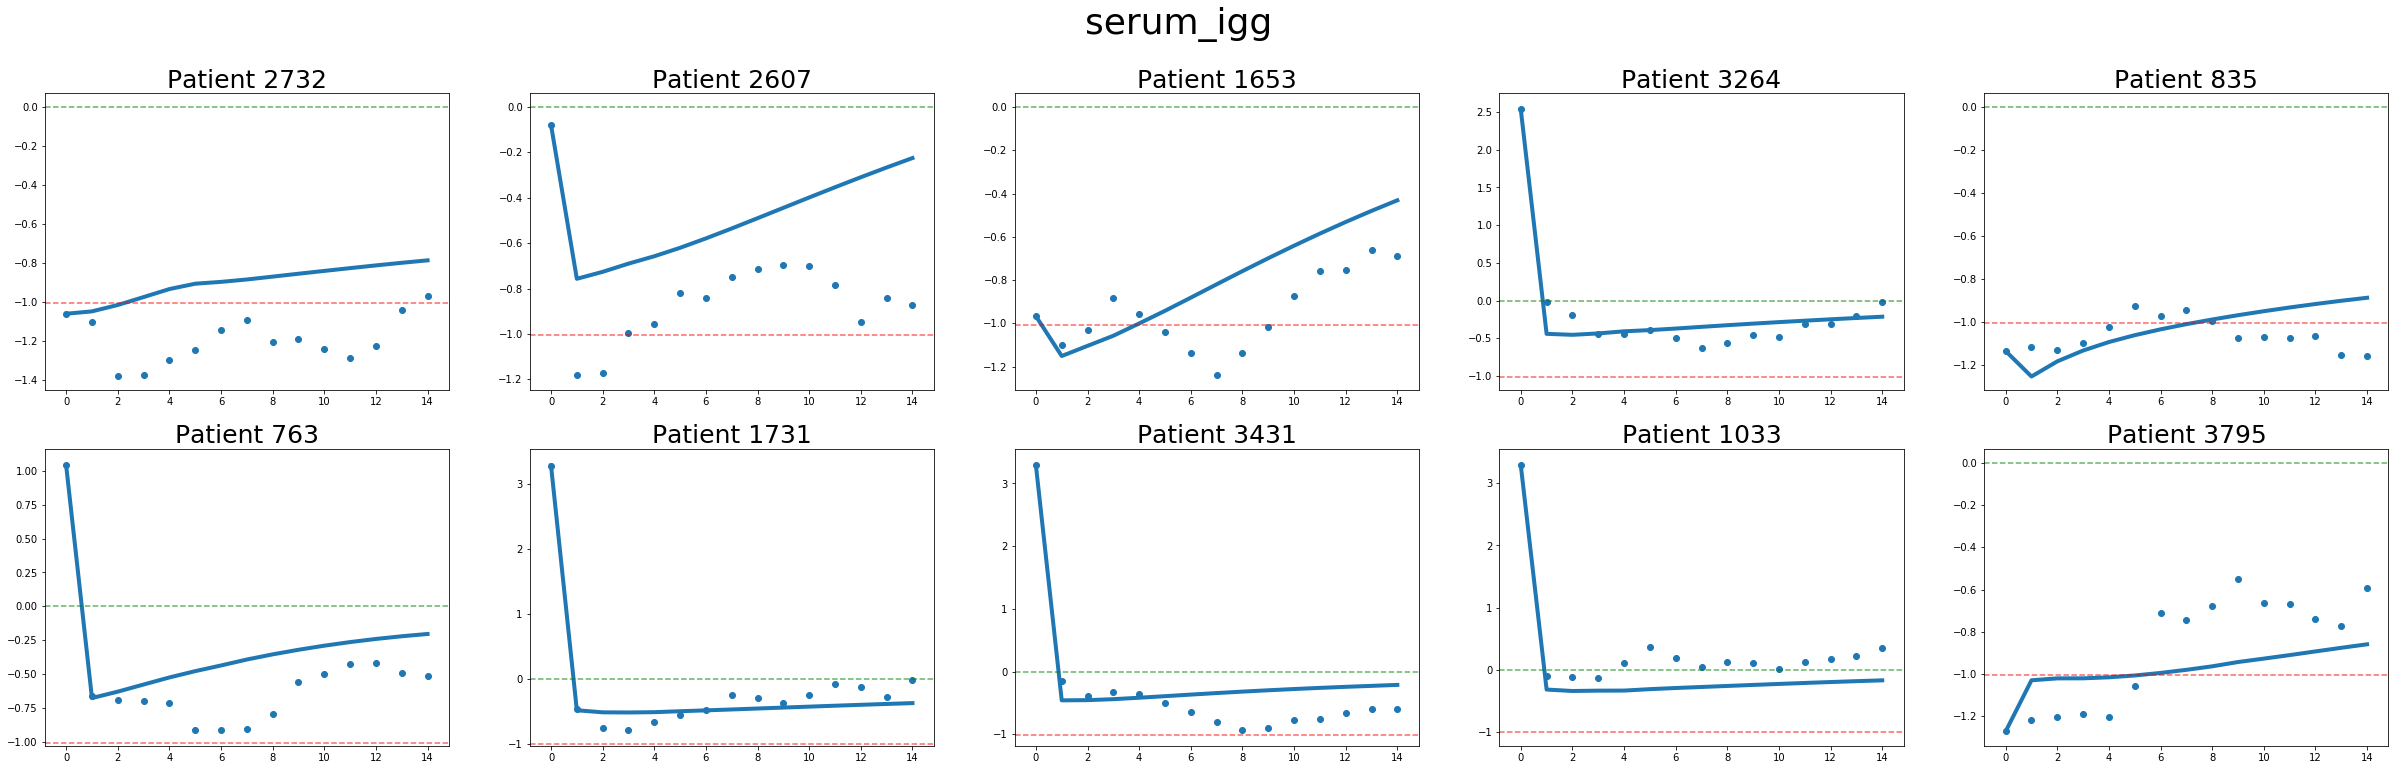

In [43]:
np.random.seed(0)
idxs = np.random.choice(np.arange(X.shape[0]),size=10)
sel_sample = sample[idxs]
orig = X[idxs]

fig, axlist = plt.subplots(2,5,figsize=(42,12))
feat  = 13
feat_name  = ddata['feature_names_x'][feat]
vmin, vmax = scaled_healthy_min_max[feat_name]
ax         = axlist.ravel()
for i,idx in enumerate(idxs): 
    ss_example   = sample[idx]
    orig_example = X[idx]
    orig_example[np.where(M[idx] == 0.)] = np.nan
    ax[i].plot(np.arange(ss_example.shape[0]), pt_numpy(ss_example[:,feat]), linewidth=4)
    ax[i].scatter(np.arange(ss_example.shape[0]), pt_numpy(orig_example[:ss_example.shape[0],feat]), s=36)
    ax[i].axhline(y=vmin, color='r', linestyle='--', alpha=0.6)
    ax[i].axhline(y=vmax, color='g', linestyle='--', alpha=0.6)
    ax[i].set_title(f'Patient {idx}', fontsize=25)
plt.suptitle(feat_name, fontsize=36)   
plt.savefig('./plots/samples_gru_igg.pdf',bbox_inches='tight')

## SSM

In [50]:
# checkpoint_path = '../ief_core/tbp_logs/checkpoints/ssm_pkpd_semi_synthetic_subsample_best_epoch=09999-val_loss=-306.21.ckpt'
checkpoint_path = '../ief_core/tbp_logs/checkpoints/ssm_lin_semi_synthetic_subsample_best_epoch=09459-val_loss=-303.40.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
hparams    = checkpoint['hyper_parameters']
ssm = SSM(**hparams); ssm.setup(1) 
ssm.load_state_dict(checkpoint['state_dict'])
assert 'dim_data' in ssm.hparams
assert 'dim_treat' in ssm.hparams
assert 'dim_base' in ssm.hparams
assert ssm.hparams['ttype'] == 'lin'


using relu in inf. network


In [51]:
valid_loader = ssm.val_dataloader()
B, X, A, M, Y, CE = valid_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
T_forward  = 15; T_condition = 4
_, _, lens = get_masks(M)
B, X, A, M, Y, CE = B[lens>T_forward+T_condition], X[lens>T_forward+T_condition], A[lens>T_forward+T_condition], M[lens>T_forward+T_condition], Y[lens>T_forward+T_condition], CE[lens>T_forward+T_condition]
_, _, _, _, _, sample = ssm.inspect(T_forward, T_condition, B, X, A, M, Y, CE)

In [52]:
print(sample.shape)
ddata = load_ss_data(10)
print(ddata['feature_names_x'])

torch.Size([3880, 15, 16])
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']


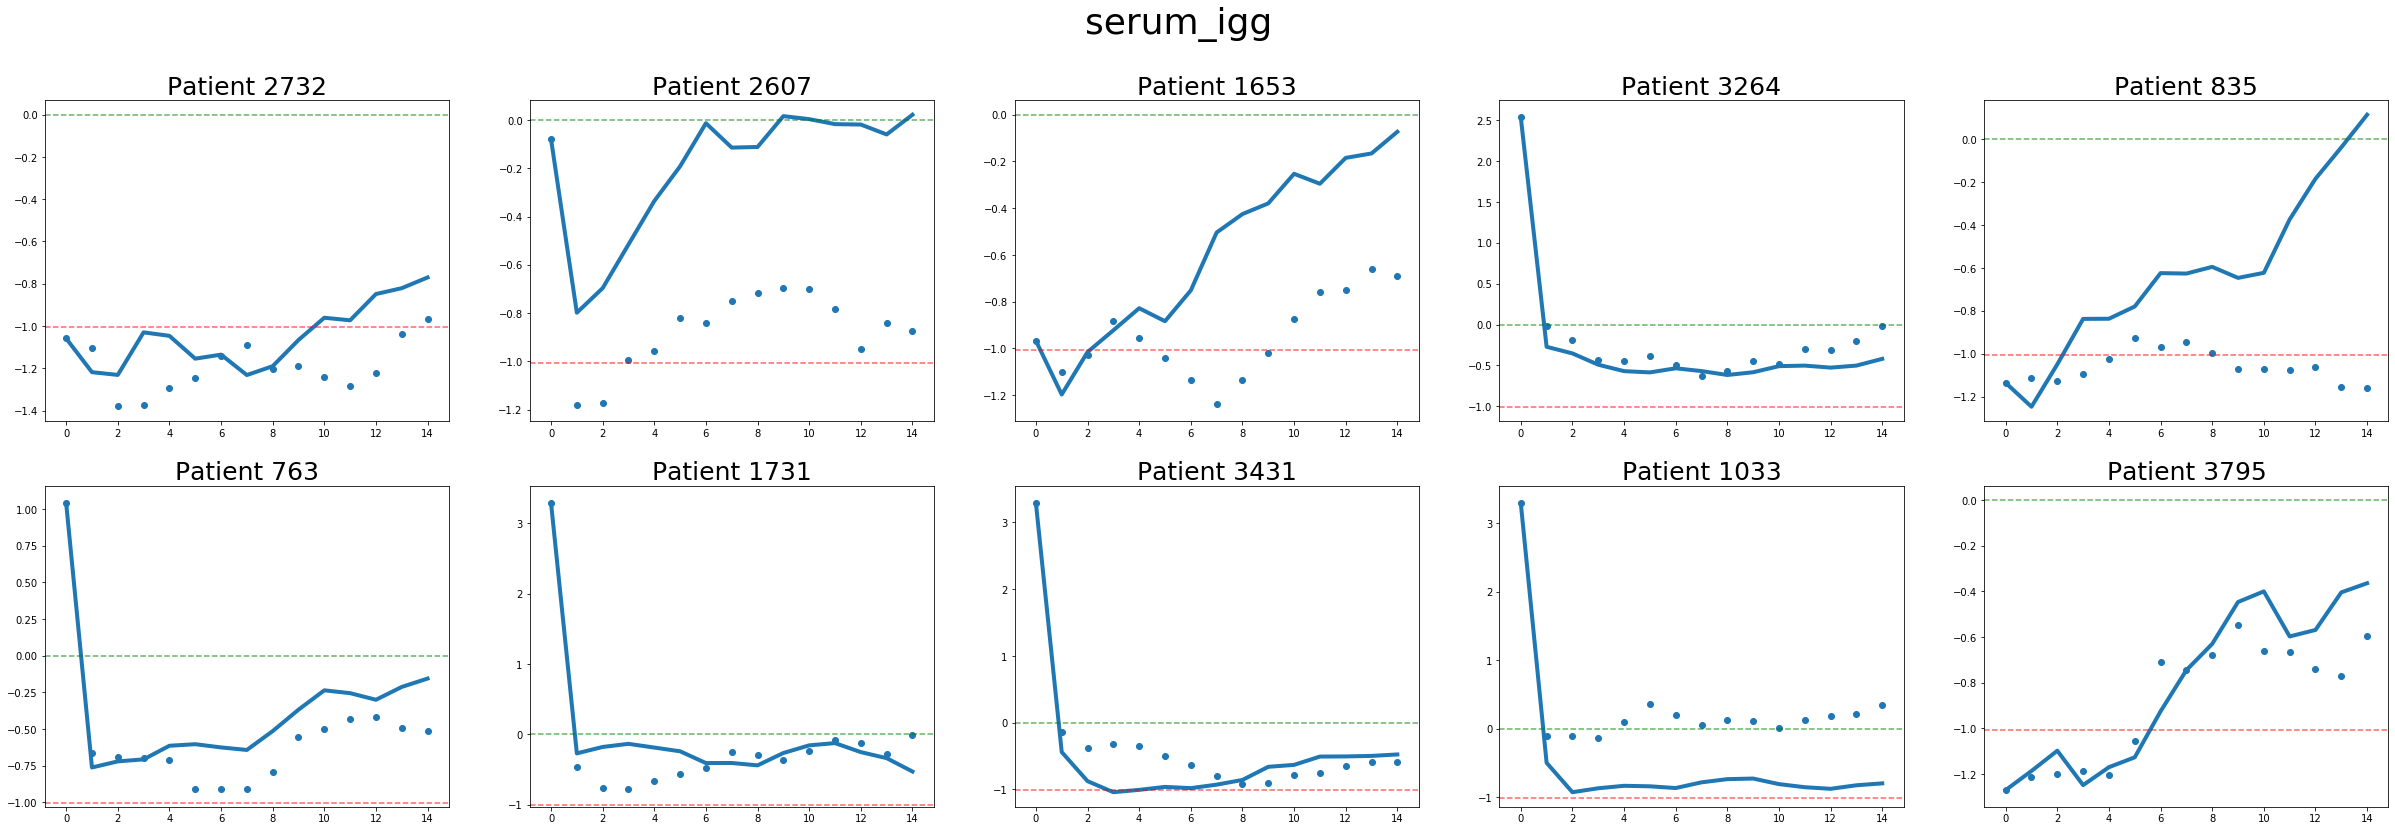

In [53]:
np.random.seed(0)
idxs = np.random.choice(np.arange(X.shape[0]),size=10)
sel_sample = sample[idxs]
orig = X[idxs]

fig, axlist = plt.subplots(2,5,figsize=(42,13))
feat  = 13
feat_name  = ddata['feature_names_x'][feat]
vmin, vmax = scaled_healthy_min_max[feat_name]
ax         = axlist.ravel()
for i,idx in enumerate(idxs): 
    ss_example   = sample[idx]
    orig_example = X[idx]
    orig_example[np.where(M[idx] == 0.)] = np.nan
    ax[i].plot(np.arange(ss_example.shape[0]),pt_numpy(ss_example[:,feat]), linewidth=4)
    ax[i].scatter(np.arange(ss_example.shape[0]), pt_numpy(orig_example[:ss_example.shape[0],feat]), s=36)
    ax[i].axhline(y=vmin, color='r', linestyle='--', alpha=0.6)
    ax[i].axhline(y=vmax, color='g', linestyle='--', alpha=0.6)
    ax[i].set_title(f'Patient {idx}', fontsize=25)
plt.suptitle(feat_name, fontsize=36)   
plt.savefig('./plots/samples_ssmlin_igg.pdf',bbox_inches='tight')